<center> <h2> ML facial recognition to detect mood and suggests songs accordingly  </h2>
    <h3> by - Dhruvee Vadhvana </h3></center> 

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline

import datetime
import os
import cv2

import tensorflow as tf
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

from keras import regularizers
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils.vis_utils import plot_model

from sklearn.metrics import classification_report, confusion_matrix

main_accent_colour = "#b366ff"
dim_colour="darkgrey"
main_palette = ["#FBE5C0", "#DD9A30", "#F88379", "#FF6FC2", "purple", "#D086F6", "#B0D2C2", "#4C5D70", "#6FA2CE", "#382D24", "#3ACF3A", "#7D7D00"]

In [10]:
train_dir = '..//train/'
test_dir = '..//test/'
row = 48
col = 48
classes = len(os.listdir('..//train/'))

In [15]:
import os
print(os.listdir('..//archive/'))

['test', 'train']


In [16]:
print('Train Directory :')
print(os.listdir('..//train/'))

Train Directory :
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [17]:
print("Test_Directory :")
print(os.listdir('..//train/'))

Test_Directory :
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [11]:
def Classes_Count( path, name):
    Classes_Dict = {}
    for Class in os.listdir(path):
        Full_Path = path + Class
        Classes_Dict[Class] = len(os.listdir(Full_Path))
    df = pd.DataFrame(Classes_Dict, index=[name])
    return df
Train_Count = Classes_Count(train_dir, 'Train').transpose().sort_values(by="Train", ascending=False)
Test_Count = Classes_Count(test_dir, 'Test').transpose().sort_values(by="Test", ascending=False)

In [12]:
pd.concat([Train_Count,Test_Count] , axis=1)

,Train,Test
disgust,18796,111
angry,14430,958
happy,7215,1774
neutral,4965,1233
sad,4830,1247
fear,4097,1024
surprise,3171,831


<Axes: >

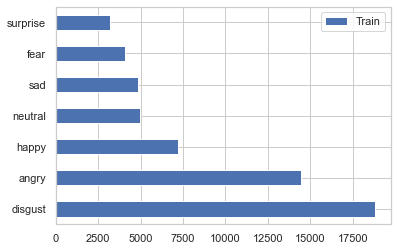

In [13]:
Train_Count.plot(kind='barh')

<Axes: >

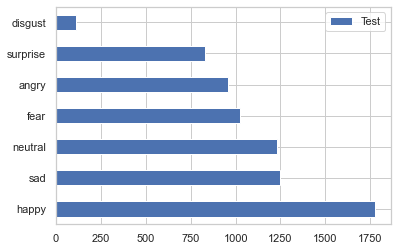

In [14]:
Test_Count.plot(kind='barh')

In [5]:
print("Train Set :")

train_count = []
for folder in os.listdir(train_dir) :
    print(folder, "folder contains\t\t", len(os.listdir(train_dir+folder)), "image")
    train_count.append(len(os.listdir(train_dir+folder)))
    
print()

test_count = []
print("Test Set :")
for folder in os.listdir(test_dir) :
    print(folder, "folder contains\t\t", len(os.listdir(test_dir+folder)), "images")
    test_count.append(len(os.listdir(test_dir+folder)))

Train Set :
angry folder contains		 14430 image
disgust folder contains		 18796 image
fear folder contains		 4097 image
happy folder contains		 7215 image
neutral folder contains		 4965 image
sad folder contains		 4830 image
surprise folder contains		 3171 image

Test Set :
angry folder contains		 958 images
disgust folder contains		 111 images
fear folder contains		 1024 images
happy folder contains		 1774 images
neutral folder contains		 1233 images
sad folder contains		 1247 images
surprise folder contains		 831 images


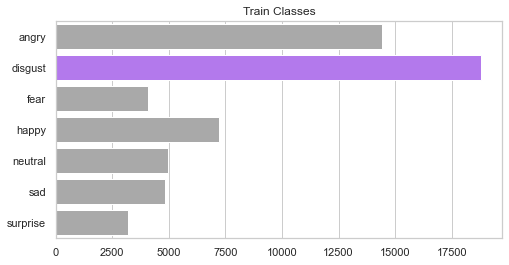

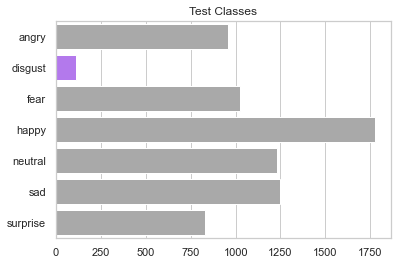

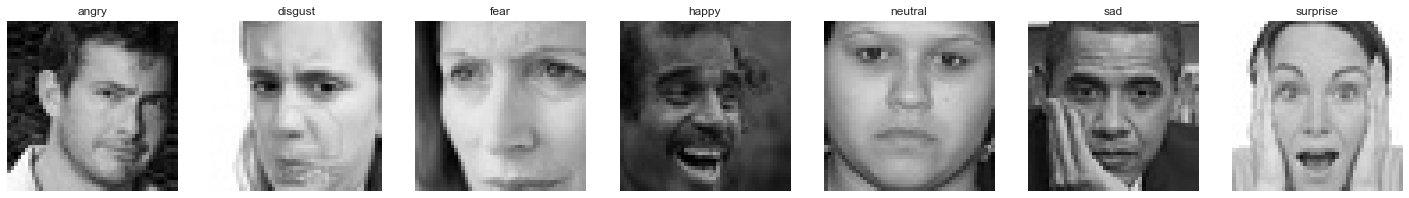

In [6]:
vals = ["disgust"]
palette = {c: dim_colour if c not in vals else main_accent_colour for c in os.listdir(train_dir)}

plt.figure(figsize=(8,4))

ax = sns.barplot(y=os.listdir(train_dir),
                 x=train_count,
                 palette=palette,
                 orientation="horizontal",
).set(title='Train Classes')

plt.show()

print()

ax = sns.barplot(y=os.listdir(test_dir),
                 x=test_count,
                 palette=palette,
                 orientation="horizontal",
).set(title='Test Classes')

plt.show()

print()

plt.figure(figsize=(25,25))

i = 1
for folder in os.listdir(train_dir):
    
    img = load_img((train_dir + folder +'/'+ os.listdir(train_dir + folder)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(folder)
    plt.axis('off')
    i += 1
    
plt.show()

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline 

In [19]:
def plot_images(img_dir, top=10):
    all_img_dirs = os.listdir(img_dir)
    img_files = [os.path.join(img_dir, file) for file in all_img_dirs][:5]
    plt.figure(figsize=(10, 10))
    for idx, img_path in enumerate(img_files):
        plt.subplot(5, 5, idx+1)
        img = plt.imread(img_path)
        plt.tight_layout()         
        plt.imshow(img, cmap='gray')

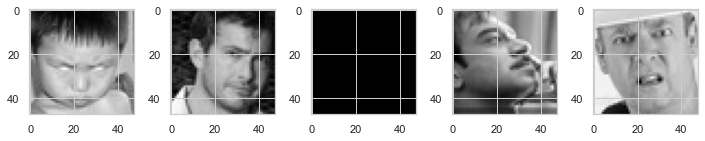

In [20]:
plot_images(train_dir+"/"+"angry")

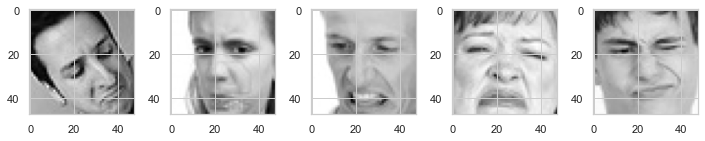

In [21]:
plot_images(train_dir+"/"+"disgust")

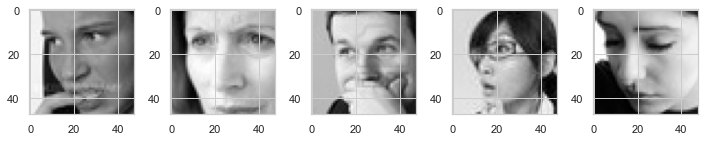

In [22]:
plot_images(train_dir+"/"+"fear")

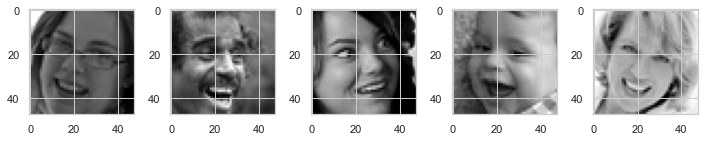

In [23]:
plot_images(train_dir+"/"+"happy")

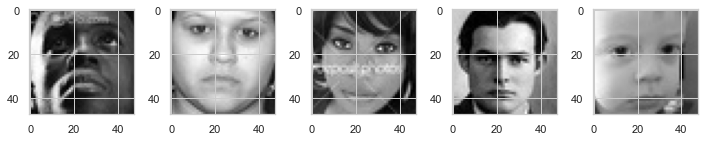

In [24]:
plot_images(train_dir+"/"+"neutral")

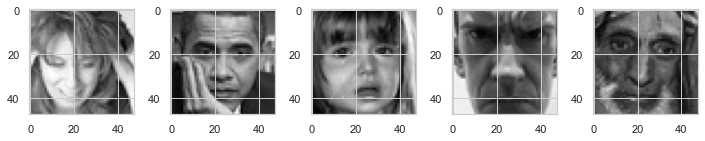

In [25]:
plot_images(train_dir+"/"+"sad")

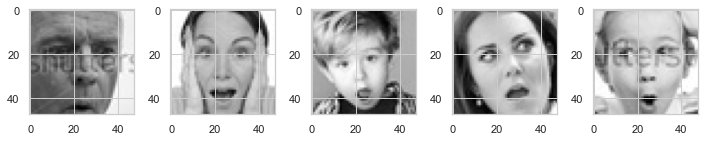

In [26]:
plot_images(train_dir+"/"+"surprise")

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 57504 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [8]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [9]:
def get_model(input_size, classes=7):
    
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))

    model.compile(optimizer=Adam(lr=0.0001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [10]:
fernet = get_model((row, col, 1), classes)
optimizer = Adam(learning_rate=0.001)  # Adjust the learning rate as needed
fernet.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

fernet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       7

C:\Users\Dhruvee Vadhvana\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [11]:
chk_path = 'ferNet.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_accuracy')

earlystop = EarlyStopping(monitor='val_accuracy', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]
callbacks 

In [12]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = fernet.fit(x=training_set,
                  validation_data=test_set,
                  epochs=50,
                  callbacks=callbacks,
                  steps_per_epoch=steps_per_epoch,
                  validation_steps=validation_steps)

Epoch 1/50
898/898 [==============================] - ETA: 0s - loss: 3.6475 - accuracy: 0.3399
Epoch 1: val_loss improved from inf to 2.71744, saving model to ferNet.h5
898/898 [==============================] - 1187s 1s/step - loss: 3.6475 - accuracy: 0.3399 - val_loss: 2.7174 - val_accuracy: 0.0438 - lr: 0.0010
Epoch 2/50
898/898 [==============================] - ETA: 0s - loss: 1.6891 - accuracy: 0.4026
Epoch 2: val_loss improved from 2.71744 to 2.24377, saving model to ferNet.h5
898/898 [==============================] - 1044s 1s/step - loss: 1.6891 - accuracy: 0.4026 - val_loss: 2.2438 - val_accuracy: 0.2090 - lr: 0.0010
Epoch 3/50
898/898 [==============================] - ETA: 0s - loss: 1.5457 - accuracy: 0.4580
Epoch 3: val_loss improved from 2.24377 to 2.01358, saving model to ferNet.h5
898/898 [==============================] - 1051s 1s/step - loss: 1.5457 - accuracy: 0.4580 - val_loss: 2.0136 - val_accuracy: 0.2878 - lr: 0.0010
Epoch 4/50
898/898 [========================

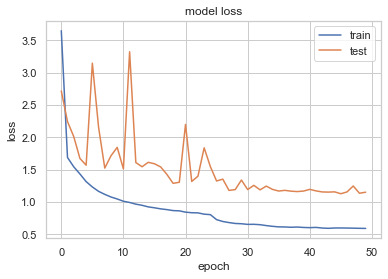

In [13]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

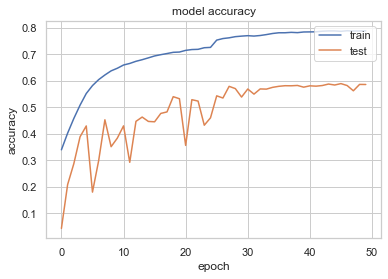

In [14]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [15]:
train_loss, train_accu = fernet.evaluate(training_set)
test_loss, test_accu = fernet.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 25s 209ms/step - loss: 1.1528 - accuracy: 0.5857
final train accuracy = 82.77 , validation accuracy = 58.57


899/899 [==============================] - 183s 200ms/step
Confusion Matrix
[[3654 4705  599 1953 1290 1498  731]
 [4658 6179  777 2482 1823 1820 1057]
 [1005 1344  143  548  401  434  222]
 [1781 2349  282  978  672  774  379]
 [1206 1655  204  694  456  478  272]
 [1247 1596  197  607  466  470  247]
 [ 830 1013  109  452  293  294  180]]
Classification Report
              precision    recall  f1-score   support

       angry       0.25      0.25      0.25     14430
     disgust       0.33      0.33      0.33     18796
        fear       0.06      0.03      0.04      4097
       happy       0.13      0.14      0.13      7215
     neutral       0.08      0.09      0.09      4965
         sad       0.08      0.10      0.09      4830
    surprise       0.06      0.06      0.06      3171

    accuracy                           0.21     57504
   macro avg       0.14      0.14      0.14     57504
weighted avg       0.21      0.21      0.21     57504



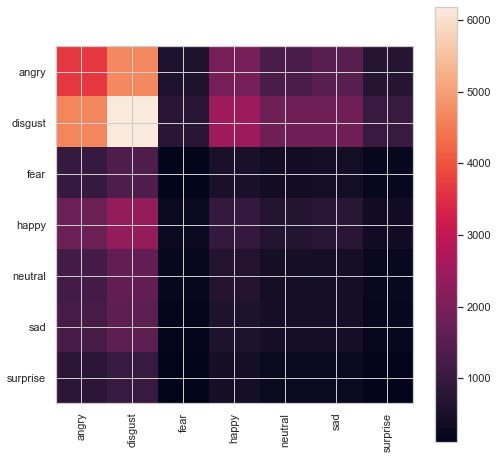

In [16]:
y_pred = fernet.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

113/113 [==============================] - 25s 205ms/step
Confusion Matrix
[[173  14  58 230 221 148 114]
 [ 14   1   8  23  24  24  17]
 [177  15  92 236 231 146 127]
 [306  15 138 450 392 277 196]
 [211   9  93 291 295 200 134]
 [213  10 120 288 289 192 135]
 [146   6  81 204 162 134  98]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.18      0.16       958
     disgust       0.01      0.01      0.01       111
        fear       0.16      0.09      0.11      1024
       happy       0.26      0.25      0.26      1774
     neutral       0.18      0.24      0.21      1233
         sad       0.17      0.15      0.16      1247
    surprise       0.12      0.12      0.12       831

    accuracy                           0.18      7178
   macro avg       0.15      0.15      0.15      7178
weighted avg       0.18      0.18      0.18      7178



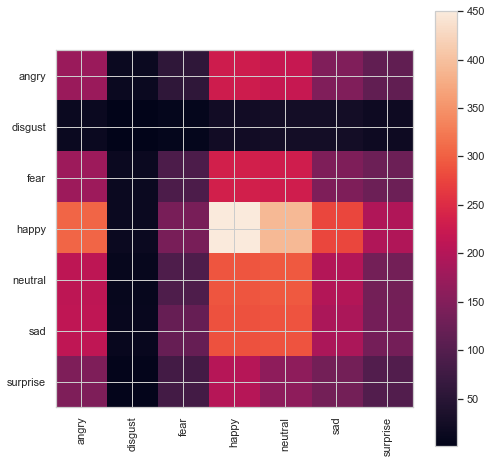

In [17]:
y_pred = fernet.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

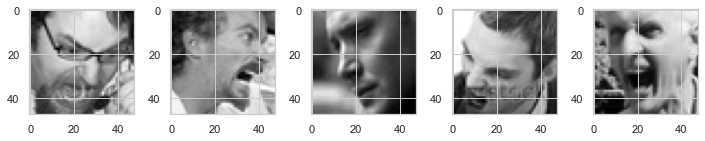

In [27]:
plot_images(test_dir+"/"+"angry")

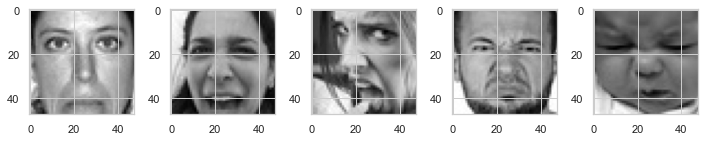

In [28]:
plot_images(test_dir+"/"+"disgust")

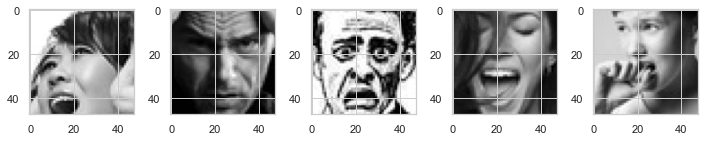

In [29]:
plot_images(test_dir+"/"+"fear")

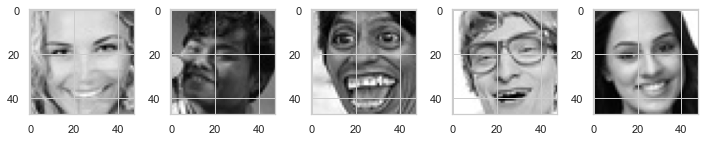

In [30]:
plot_images(test_dir+"/"+"happy")

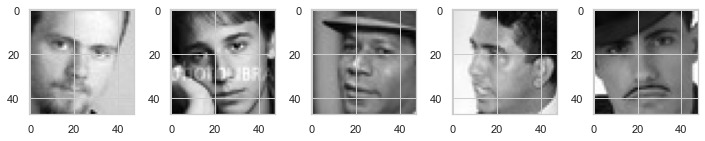

In [31]:
plot_images(test_dir+"/"+"neutral")

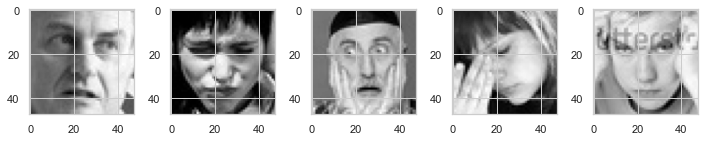

In [32]:
plot_images(test_dir+"/"+"sad")

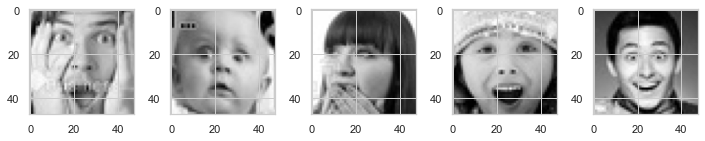

In [33]:
plot_images(test_dir+"/"+"surprise")

In [37]:
mood_music = pd.read_csv("..//data_moods.csv")
mood_music.head()

,name,album,artist,id,release_date,popularity,length,danceability,acousticness,energy,instrumentalness,liveness,valence,loudness,speechiness,tempo,key,time_signature,mood
0,1999,1999,Prince,2H7PHVdQ3mXqEHXcvclTB0,1982-10-27,68,379266,0.866,0.13700,0.730,0.000000,0.0843,0.625,-8.201,0.0767,118.523,5,4,Happy
1,23,23,Blonde Redhead,4HIwL9ii9CcXpTOTzMq0MP,2007-04-16,43,318800,0.381,0.01890,0.832,0.196000,0.1530,0.166,-5.069,0.0492,120.255,8,4,Sad
2,9 Crimes,9,Damien Rice,5GZEeowhvSieFDiR8fQ2im,2006-11-06,60,217946,0.346,0.91300,0.139,0.000077,0.0934,0.116,-15.326,0.0321,136.168,0,4,Sad
3,99 Luftballons,99 Luftballons,Nena,6HA97v4wEGQ5TUClRM0XLc,1984-08-21,2,233000,0.466,0.08900,0.438,0.000006,0.1130,0.587,-12.858,0.0608,193.100,4,4,Happy
4,A Boy Brushed Red Living In Black And White,They're Only Chasing Safety,Underoath,47IWLfIKOKhFnz1FUEUIkE,2004-01-01,60,268000,0.419,0.00171,0.932,0.000000,0.1370,0.445,-3.604,0.1060,169.881,1,4,Energetic


In [42]:
mood_music = pd.read_csv("..//data_moods.csv")
mood_music = mood_music[['name','artist','mood']]
mood_music.head()

,name,artist,mood
0,1999,Prince,Happy
1,23,Blonde Redhead,Sad
2,9 Crimes,Damien Rice,Sad
3,99 Luftballons,Nena,Happy
4,A Boy Brushed Red Living In Black And White,Underoath,Energetic


(48, 48)


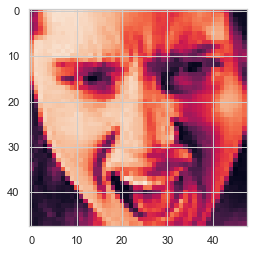

In [43]:
from keras.utils import load_img
img = load_img("..//test/angry/PrivateTest_2775163.jpg",target_size = (48,48),color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)
print(img.shape)

In [44]:
training_set.class_indices
label_dict = ['angry', 'disgust', 'fear','happy', 'neutral', 'sad', 'surprise']

In [45]:
from keras.utils import img_to_array
test_image = img_to_array(img)
test_image = np.expand_dims(test_image, axis = 0)
result = fernet.predict(test_image)
result[0]

1/1 [==============================] - 2s 2s/step


array([1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [46]:
res = np.argmax(result[0])
res

0

In [47]:
print('predicted Label for that image is: {}'.format(label_dict[res]))

predicted Label for that image is: angry


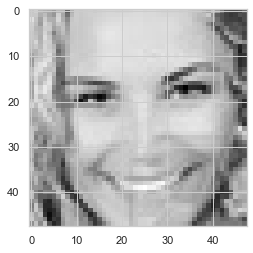

In [30]:
image = cv2.imread('..//test/happy/PrivateTest_10077120.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(image,cmap='gray')
plt.show()

In [31]:
image = cv2.resize(image,(48,48))
img=np.array(image)
img=img.reshape(1,48,48,1)
predict_x=fernet.predict(img) 
result=np.argmax(predict_x,axis=1)
result[0]

1/1 [==============================] - 2s 2s/step


3

In [32]:
if(result[0]==0 or result[0]==1 or result[0]==2 ):
    #for angery,disgust,fear
    filter1=mood_music['mood']=='Calm'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)
if(result[0]==3 or result[0]==4):
    #for happy, neutral
    filter1=mood_music['mood']=='Happy'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)
if(result[0]==5):
       #for Sad
    filter1=mood_music['mood']=='Sad'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)
if(result[0]==6):
     #for surprise
    filter1=mood_music['mood']=='Energetic'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)

,index,name,artist,mood
0,112,Crash,Chris Malinchak,Happy
1,103,Come On Eileen,Dexys Midnight Runners,Happy
2,146,Don't Stop Me Now - 2011 Mix,Queen,Happy
3,153,Driver's Seat,Sniff 'n' The Tears,Happy
4,207,Geno - 2000 Remaster,Dexys Midnight Runners,Happy


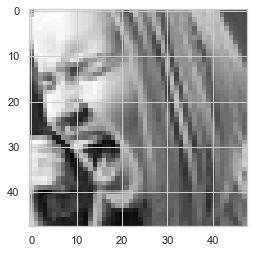

In [19]:
image = cv2.imread('..//test/angry/PrivateTest_39884579.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(image,cmap='gray')
plt.show()

In [20]:
image = cv2.resize(image,(48,48))
img=np.array(image)
img=img.reshape(1,48,48,1)
predict_x=fernet.predict(img) 
result=np.argmax(predict_x,axis=1)
result[0]

1/1 [==============================] - 4s 4s/step


0

In [21]:
if(result[0]==0 or result[0]==1 or result[0]==2 ):
    
    #for angry,disgust,fear
    filter1=mood_music['mood']=='Calm'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)
if(result[0]==3 or result[0]==4):
    
    #for happy, neutral
    filter1=mood_music['mood']=='Happy'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)
if(result[0]==5):
    
    #for Sad
    filter1=mood_music['mood']=='Sad'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)
if(result[0]==6):
    
    #for surprise
    filter1=mood_music['mood']=='Energetic'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)

,index,name,artist,mood
0,332,Lunar Eclipse,Marc Torch,Calm
1,50,Bayybe 07,Bilo 503,Calm
2,345,Mind-wanders,Patrick Hamilton,Calm
3,438,Raven's Feather - Piano Solo,Nina June,Calm
4,6,A La Plage,Ron Adelaar,Calm
